# Modelo Machine Learning

In [1]:
import pandas as pd
from joblib import load, dump
import time
from sklearn.linear_model import (HuberRegressor, RANSACRegressor, TheilSenRegressor, 
                                  LassoLars, LinearRegression, Ridge, Lasso, 
                                  OrthogonalMatchingPursuit, BayesianRidge, SGDRegressor)
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
escalador = MinMaxScaler()

In [3]:
def entrenar_modelo(listaModelos: dict, X_train, y_train, X_test, y_test):

    if type(y_train) == pd.DataFrame:
        # Convertir y_train a una serie unidimensional
        y_train = y_train.squeeze()
    else:
        # O si necesitas un array unidimensional
        y_train = y_train.ravel()

    nombres_modelos = list(listaModelos.keys())

    rmse_scores_train = []
    r2_scores_train = []

    rmse_scores_test = []
    r2_scores_test = []

    tiempos_train = []  # Lista para almacenar los tiempos de entrenamiento
    tiempos_prueba = []  # Lista para almacenar los tiempos de testing


    # Iterar a través de cada modelo
    for nombre_modelo, modelo in listaModelos.items():

        # Entrenar el modelo
        if nombre_modelo == 'Interactions Linear':
            modelo = make_pipeline(escalador, PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), modelo)
        else:
            modelo = make_pipeline(escalador, modelo)

        listaModelos[nombre_modelo] = modelo # Actualizo diccionario con el pipeline

        #Train
        start_time_train = time.perf_counter()
        modelo.fit(X_train, y_train)  # Entrenar el modelo
        tiempo_entrenamiento = time.perf_counter() - start_time_train
        y_pred_train = modelo.predict(X_train)

        
        #Test
        start_time_test = time.perf_counter()
        y_pred_test = modelo.predict(X_test)
        tiempo_prueba = time.perf_counter() - start_time_test
        
        
        # Calcular RMSE y R^2
        rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        r2_train = r2_score(y_train, y_pred_train)

        rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
        r2_test = r2_score(y_test, y_pred_test)

        if r2_test > 0.5:
            rmse_scores_train.append(rmse_train)
            r2_scores_train.append(r2_train)

            rmse_scores_test.append(rmse_test)
            r2_scores_test.append(r2_test)

            tiempos_train.append(tiempo_entrenamiento*1000)
            tiempos_prueba.append(tiempo_prueba*1000)
        else: 
            nombres_modelos.remove(nombre_modelo)

    indices_ordenados = [rmse_scores_test.index(i) for i in sorted(rmse_scores_test)]

    for i, indice in enumerate(indices_ordenados):
        print(f"Número {i+1}:")
        print(f"Modelo: {nombres_modelos[indice]}")
        print(f"(TRAIN) RMSE: {rmse_scores_train[indice]}, R^2: {r2_scores_train[indice]}")
        print(f"(TEST) RMSE: {rmse_scores_test[indice]}, R^2: {r2_scores_test[indice]}")
        print(f"Tiempo de entrenamiento: {tiempos_train[indice]:.10f} milisegundos")
        print(f"Tiempo de prediccion (TEST): {tiempos_prueba[indice]:.10f} milisegundos", end='\n'*4)          

    indice_mejor_modelo = indices_ordenados.pop(0)
    mejor_modelo = listaModelos[nombres_modelos[indice_mejor_modelo]]

    #Print de los resultados estadísticos (opcional - se puede comentar)
    print('*'*175)
    print(f"Mejor modelo: {nombres_modelos[indice_mejor_modelo]}, (TEST) RMSE: {rmse_scores_test[indice_mejor_modelo]}, R^2: {r2_scores_test[indice_mejor_modelo]}, tiempo de entrenamiento de {tiempos_train[indice_mejor_modelo]:.10f} segundos")
    print('*'*175)
    #Print de los resultados estadísticos (opcional - se puede comentar)
    return mejor_modelo

# DATASET

In [4]:
columnas_X= ['potencia', 'frecuencia', 'workstation_ram']
target = 'energia'
columnas = columnas_X + [target]

In [5]:
entrenamiento = 'G:\\.shortcut-targets-by-id\\1LnoFimDlQwBxnQ9oNCDgkRuGNz-Ae50P\\ProyectosTRI\\Consumo_Energetico\\Dataset\\Interpolacion_Datos\\dataset_sin_interpolacion\\may-jun2021_hora_sin_interpolacion.csv'
testing = 'G:\\.shortcut-targets-by-id\\1LnoFimDlQwBxnQ9oNCDgkRuGNz-Ae50P\\ProyectosTRI\\Consumo_Energetico\\Dataset\\Interpolacion_Datos\\dataset_sin_interpolacion\\may-jun2022_hora_sin_interpolacion.csv'

In [6]:
# Leer los DataFrames
dataframe_train = pd.read_csv(entrenamiento)
dataframe_testing = pd.read_csv(testing)

In [7]:
X_train = dataframe_train[columnas_X]
y_train = dataframe_train[[target]]

X_test = dataframe_testing[columnas_X]
y_test = dataframe_testing[[target]]

# Entramiento

In [8]:
listaModelos = {"Linear Regression":LinearRegression(), "Interactions Linear":LinearRegression(), 
                "Robust Linear (HUBER)":HuberRegressor(), "Stepwise Linear":RFE(estimator=LinearRegression(), n_features_to_select=1),
                "Robust Linear (RANSAC)":RANSACRegressor(), "TheilSenRegressor":TheilSenRegressor(), "LassoLars":LassoLars(normalize=False),
                "Ridge": Ridge(), "Lasso": Lasso(), "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(normalize=False),
                "BayesianRidge": BayesianRidge(), "SGDRegressor":SGDRegressor()}

In [9]:
start_time_ejecucion = time.perf_counter()
mejor_modelo = entrenar_modelo(listaModelos=listaModelos, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
end_time_ejecucion = time.perf_counter()

Número 1:
Modelo: BayesianRidge
(TRAIN) RMSE: 0.004618574897932929, R^2: 0.688310963572643
(TEST) RMSE: 0.0013624914507925883, R^2: 0.9390919115132821
Tiempo de entrenamiento: 2.8864000000 milisegundos
Tiempo de prediccion (TEST): 1.0614000000 milisegundos



Número 2:
Modelo: Linear Regression
(TRAIN) RMSE: 0.004618535020851221, R^2: 0.6883163458369951
(TEST) RMSE: 0.0013645746830534893, R^2: 0.9389055137224911
Tiempo de entrenamiento: 4.2577000000 milisegundos
Tiempo de prediccion (TEST): 1.1446000000 milisegundos



Número 3:
Modelo: OrthogonalMatchingPursuit
(TRAIN) RMSE: 0.004622275765776541, R^2: 0.6878112500827223
(TEST) RMSE: 0.0013919883754133632, R^2: 0.9364261350293834
Tiempo de entrenamiento: 2.6045000000 milisegundos
Tiempo de prediccion (TEST): 1.0529000000 milisegundos



Número 4:
Modelo: Stepwise Linear
(TRAIN) RMSE: 0.004622275765776541, R^2: 0.6878112500827223
(TEST) RMSE: 0.0013919883754133654, R^2: 0.9364261350293832
Tiempo de entrenamiento: 4.6780000000 milisegund

In [10]:
tiempo_ejecucion = end_time_ejecucion - start_time_ejecucion
print('Tiempo de ejecución del algoritmo: ', tiempo_ejecucion, 'segundos')

Tiempo de ejecución del algoritmo:  0.6582131000000002 segundos


# Analisis del modelo

# Ajuste de hiperparámetros (OPCIONAL)

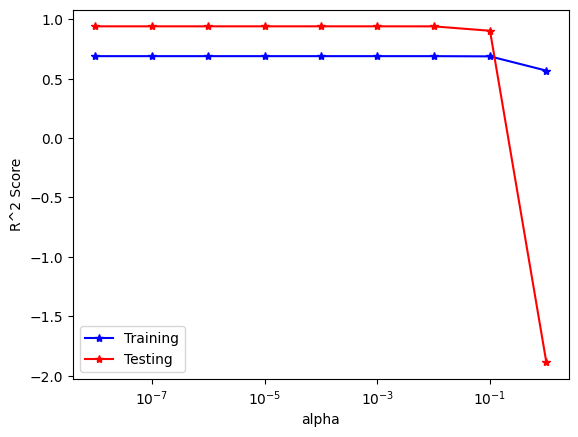

Alpha list:  [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
Test Scores:  [0.9390919007331756, 0.9390919017135716, 0.9390919115132821, 0.9390920090854666, 0.9390929423302403, 0.9390980419294724, 0.9387395577658579, 0.9018326319558294, -1.8857028848955881]
Train Scores:  [0.6883109656131643, 0.688310965427678, 0.688310963572643, 0.688310945005028, 0.6883107576030543, 0.6883087115873573, 0.6882715961581332, 0.6865329603364373, 0.5666198918964225]
Best score (test): 0.9390980419294724 with alpha = 0.001


In [11]:
# Lista de valores para alpha_1 y alpha_2
alpha_list = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

if type(y_train) == pd.DataFrame:
    # Convertir y_train a una serie unidimensional
    y_train = y_train.squeeze()
else:
    # O si necesitas un array unidimensional
    y_train = y_train.ravel()

train_scores = []
test_scores = []
models = []

for alpha in alpha_list:
    model = make_pipeline(escalador, BayesianRidge(alpha_1=alpha, alpha_2=alpha)).fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    models.append(model)

best_model_index = test_scores.index(max(test_scores))
# Graficar los resultados
plt.plot(alpha_list, train_scores, 'b*-', label='Training')
plt.plot(alpha_list, test_scores, 'r*-', label='Testing')
plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.xlabel('alpha')
plt.ylabel('R^2 Score')
plt.legend(loc='best')
plt.show()

print('Alpha list: ', alpha_list)
print('Test Scores: ', test_scores)
print('Train Scores: ', train_scores)
#print(f"Best score (train): {max(train_scores)} with alpha = {alpha_list[train_scores.index(max(train_scores))]}")
print(f"Best score (test): {max(test_scores)} with alpha = {alpha_list[best_model_index]}")

In [12]:
mejor_modelo = models[best_model_index]

In [13]:
mejor_modelo.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('bayesianridge', BayesianRidge(alpha_1=0.001, alpha_2=0.001))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'bayesianridge': BayesianRidge(alpha_1=0.001, alpha_2=0.001),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'bayesianridge__alpha_1': 0.001,
 'bayesianridge__alpha_2': 0.001,
 'bayesianridge__alpha_init': None,
 'bayesianridge__compute_score': False,
 'bayesianridge__copy_X': True,
 'bayesianridge__fit_intercept': True,
 'bayesianridge__lambda_1': 1e-06,
 'bayesianridge__lambda_2': 1e-06,
 'bayesianridge__lambda_init': None,
 'bayesianridge__n_iter': 300,
 'bayesianridge__normalize': 'deprecated',
 'bayesianridge__tol': 0.001,
 'bayesianridge__verbose': False}

# Guardar modelo

In [14]:
#dump(mejor_modelo, 'G:\\.shortcut-targets-by-id\\1LnoFimDlQwBxnQ9oNCDgkRuGNz-Ae50P\\ProyectosTRI\\Dataset\\mayo_junio_2021_2022\\modelo_ML_python\\modelo_pipeline.joblib')

# Importar modelo

In [15]:
#modelo_machine_learning = load('G:\\.shortcut-targets-by-id\\1LnoFimDlQwBxnQ9oNCDgkRuGNz-Ae50P\\ProyectosTRI\\Dataset\\mayo_junio_2021_2022\\modelo_ML_python\\modelo_pipeline.joblib')